# Снижение размерности пространства

Визуализация данных помогает понять их структуру и, как следствие, подсказывает методы анализа этих данных. Однако отображение многомерных данных на плоскости упирается в слишком большое количество измерений. Следовательно, встает задача отображения большого числа измерений на плоскость.

Ниже генерируются данные состоящие из трех четырехмерных сфер, точки в которых распределены нормально. Если мы построим их четырехмерный эпюр, то границу между этими сферами не будет видно.

In [4]:
from sklearn.datasets import make_blobs

# Интерактивный режим отображения рисунков - масштабирование, перемещение, вращение, ...
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
blob_X, y = make_blobs(n_samples=[30, 30, 30], centers=[[-7, -7, -7, -7], [0, 0, 0, 0], [7, 7, 7, 7]], 
                  cluster_std=2.3, random_state=77)

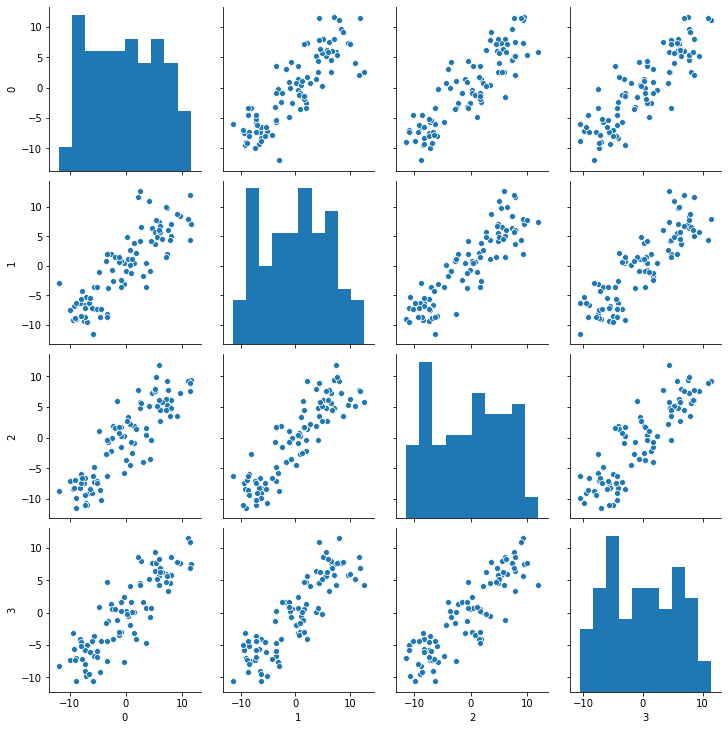

In [5]:
# Построение четырехмерного эпюра для сгенерированных данных.
sns.pairplot(pd.DataFrame(blob_X));

Однако, если подобрать правильную проекцию для отображаемых данных, то сразу станет видно, что сгенерированные сферы не пересекаются (или почти не пересекаются).

Подберем такую проекцию при помощи метода PCA.

In [6]:
from sklearn.decomposition import PCA

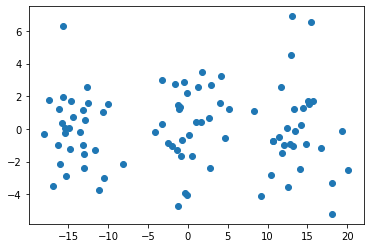

In [7]:
show_reduced = PCA(n_components=2).fit_transform(blob_X)
plt.scatter([x[0] for x in show_reduced], [x[1] for x in show_reduced]);

Один из методов такого отображения  Например,

Теперь подробнее рассмотрим <a href="https://habr.com/post/304214/">метод главных компонент</a> (<i>PCA, Principle Component Analysis, <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html"> документация</a></i>, можно немного потрогать руками <a href="https://setosa.io/ev/principal-component-analysis/">здесь</a>, с большим количеством математики метод описывается на <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82">machinelearning.ru</a>). Его суть состоит в том, что мы преобразуем пространство в новое, имеющее меньшую размерность, и строим проекцию на него. Для этого находится новая ось, вдоль которой относительная дисперсия наших данных максимальна. Далее строится проекция всех точек на эту ось, а полученные значения становятся первой координатой в новом пространстве. Это направление отбрасывается, после чего можно снова попытаться найти еще одну ось, еще одну и т.д. Операцию можно повторить столько раз, сколько измерений должно быть в новом пространстве.

![](img/correlated_2d.png)

По умолчанию PCA строит преставление пространства той же размерности, что и входные данные, однако сортирует измерения по "важности".<br>
При помощи функции fit_transform мы настраиваем коэффициенты преобразования (fit) и преобразуем переданные точки (transform). Каждое из этих действий для PCA можно производить по отдельности.<br>

Посмотрим как метод себя ведет на некоторых простых данных. Есть линия со случайными смещениями, к которой прибавлена относительно плоская область, идущая вдоль той же линии ("палочка" + "половинка монетки"). Посмотрим на ее преобразования при помощи метода главных компонент.

In [8]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

In [9]:
np.random.seed(17)
pca_len=100

In [10]:
pca_coord=np.zeros((pca_len, 3))
pca_coord2=np.zeros((int(pca_len/2), 3))

pca_coord[:,0]=np.arange(pca_len)
pca_coord[:,1]=3*pca_coord[:,0]+np.random.normal(scale=3., size=(pca_len))
pca_coord[:,2]=5*pca_coord[:,0]+np.random.normal(scale=5., size=(pca_len))

pca_coord2[:,0]=np.arange(pca_len/4, 3*pca_len/4)
pca_coord2[:,1]=[3*x+(int(pca_len/2)-np.abs(x-int(pca_len/2)))*np.random.uniform(0, 5, 1) for x in pca_coord2[:,0]]
pca_coord2[:,2]=[5*x+(int(pca_len/2)-np.abs(x-int(pca_len/2)))*np.random.uniform(0, 1, 1) for x in pca_coord2[:,0]]

pca_coord=np.vstack((pca_coord, pca_coord2))

Для начала нарисуем данные при помощи seaborn.

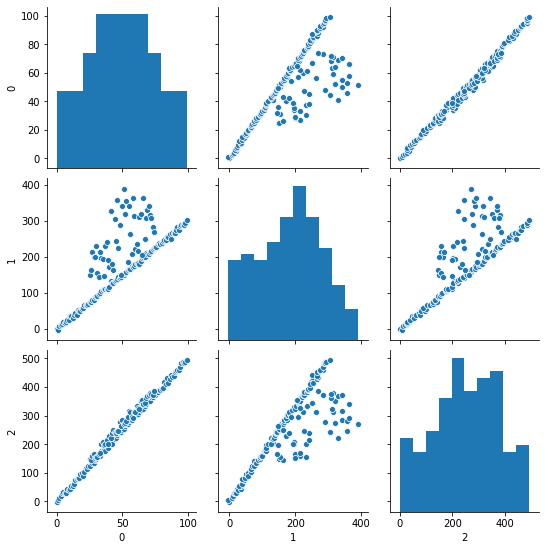

In [11]:
sns.pairplot(pd.DataFrame(pca_coord));

In [12]:
pca=PCA(n_components=2) # Просим PCA вернуть 2 коодинаты. По умолчанию вернет столько же, сколько подадим на вход.
show_reduced = pca.fit_transform(pca_coord)
pca_coord.shape, show_reduced.shape

((150, 3), (150, 2))

Плюсом метода PCA является тот факт, что после нахождения осей в новое пространство можно преобразовать любую точку исходного пространства. Это возможно, так как преобразование сводится к повороту, масштабированию и проекции.

In [13]:
# Координаты осей в исходном пространстве.
pca.components_

array([[-0.15786887, -0.57311394, -0.8041255 ],
       [-0.13885943,  0.81913003, -0.55654654]])

In [14]:
def plot_PCA(pca_coord):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=60, azim=150) # Рисуем трехмерную картинку.
    ax.scatter(pca_coord[:, 0], pca_coord[:, 1], pca_coord[:, 2], 
               cmap=plt.cm.Set1, edgecolor='g', s=40)
    ax.set_title("Simple Data")

    plt.show()

    pca=PCA(n_components=2) # Просим PCA вернуть 2 коодинаты. По умолчанию вернет столько же, сколько подадим на вход.
    show_reduced = pca.fit_transform(pca_coord)

    fig, ax = plt.subplots() # Рисуем двумерную картинку.
    ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
               cmap=plt.cm.autumn, edgecolor='b', s=40)
    plt.show()
    

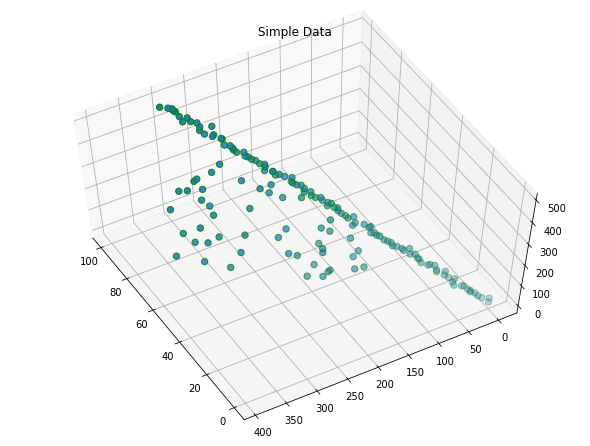

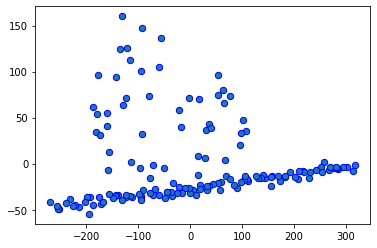

In [15]:
plot_PCA(pca_coord)

Мы видим, что PCA в самом деле повернул систему координат так, чтобы наши данные оказались максимально "в профиль".

Теперь переместим "половинку монетки" из середины "палочки" к одному из ее концов.

<IPython.core.display.Javascript object>


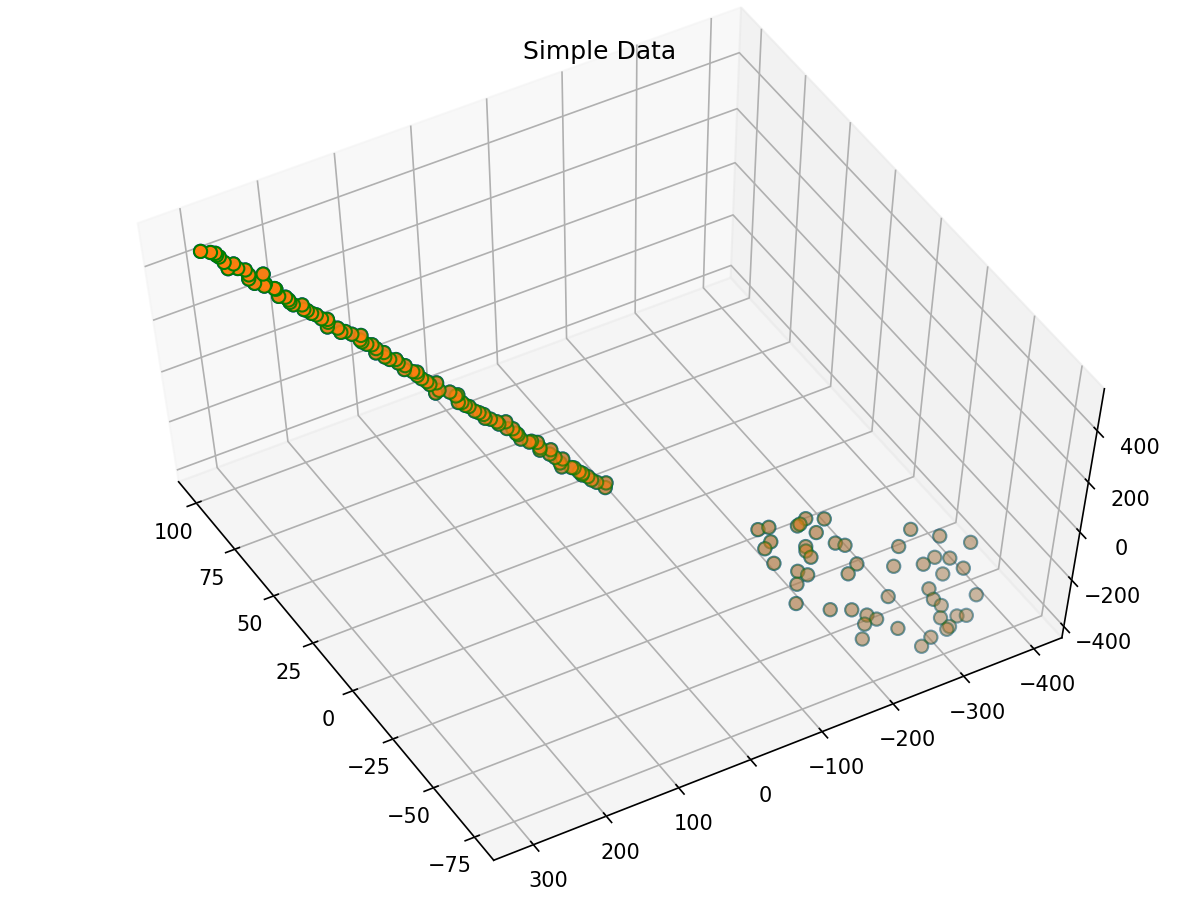

<IPython.core.display.Javascript object>


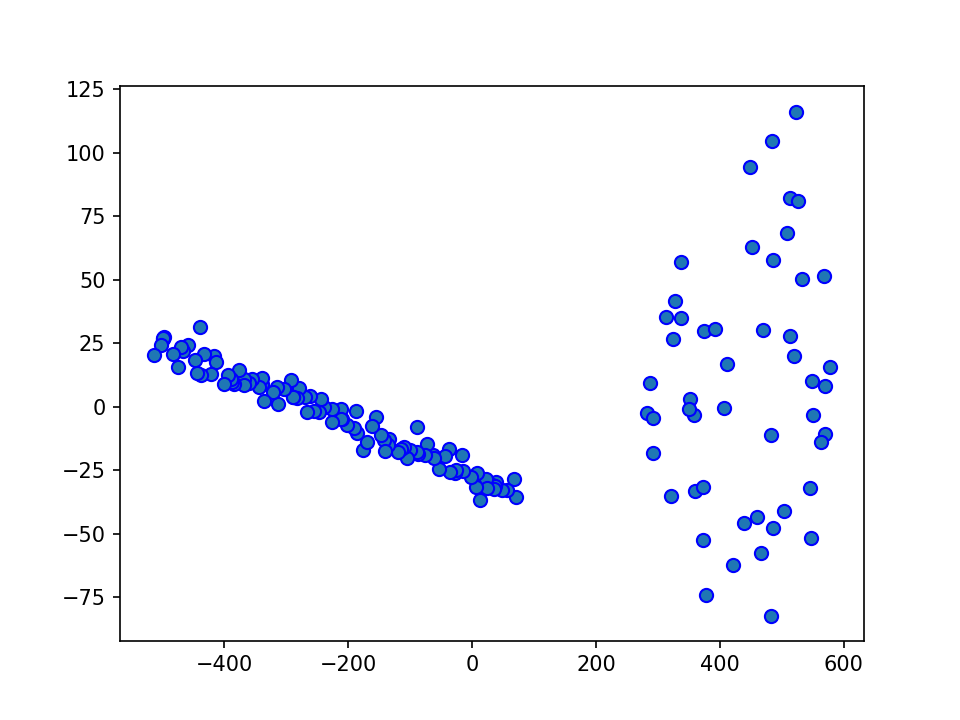

In [5]:
pca_coord3=np.vstack((pca_coord[:pca_len], -pca_coord2))
plot_PCA(pca_coord3)

Метод MDS (<i>Multidimensional Scaling</i>) поступает примерно по тому же принципу, но работает несколько быстрее и лучше. Идея метода состоит в том, что он пытается перейти в пространство меньшей размерности так, чтобы расстояния между объектами в новом пространстве были подобны расстояниям в исходном пространстве.

Однако в отличие от PCA он не умеет сохранять коэффициенты преобразования и использовать их для преобразования новых данных.

In [16]:
from sklearn.manifold import MDS

<IPython.core.display.Javascript object>


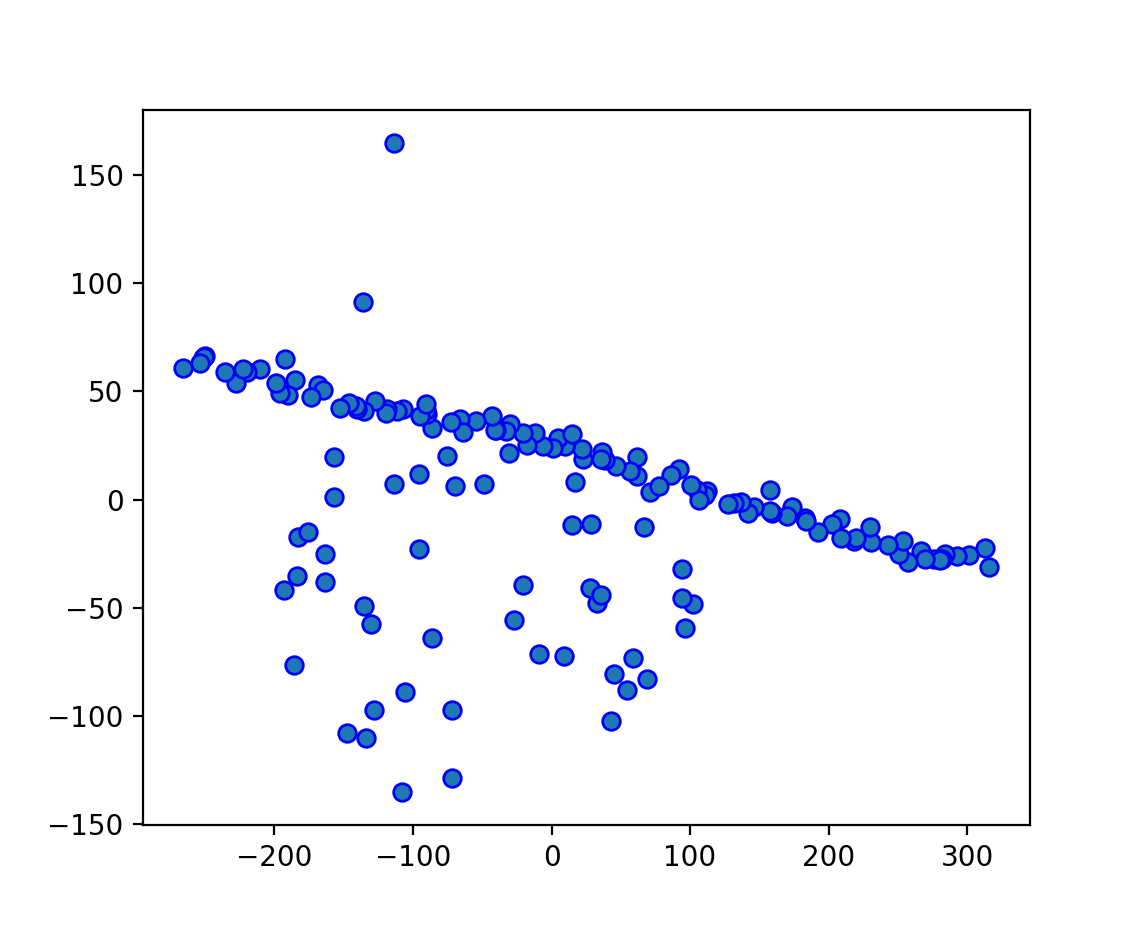

In [6]:
mds=MDS(random_state=1023)
show_reduced = mds.fit_transform(pca_coord)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

<IPython.core.display.Javascript object>


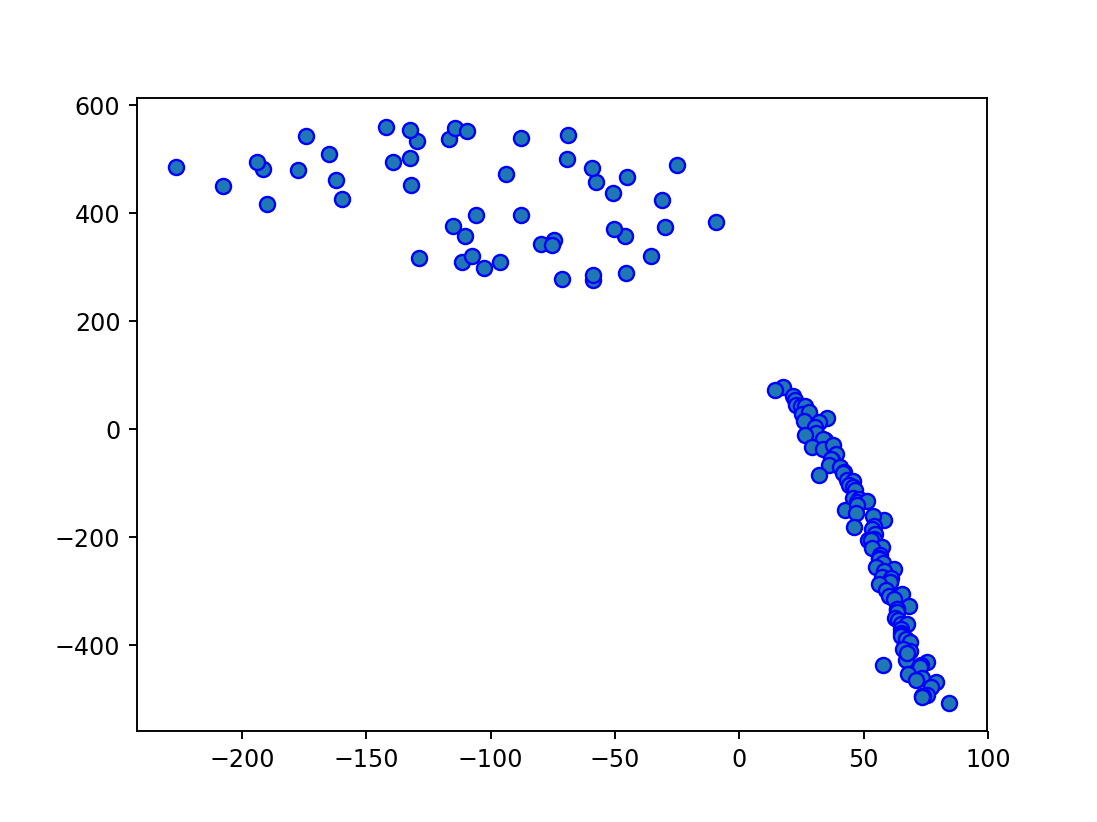

In [8]:
mds=MDS(random_state=1023)
show_reduced = mds.fit_transform(pca_coord3)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

Еще одним методом является t-SNE (<i>t-distributed stochastic neighbor embedding</i>). В отличие от предыдущих двух методов, он не строит проекции, а пытается "вдавить" точки в пространство заданной размерности, соблюдая при этом примерное расположение точек. Очевидно, полностью сохранить расположение получается не всегда, но алгоритм старается сделать так, чтобы соседние точки остались соседними.<br>
Как и MDS, t-SNE принципиально не умеет сохранять правила преобразования пространства, так что преобразовывать надо все точки сразу.<br>
Простое и понятное объяснение, а также визуализацию результатов можно найти [здесь](https://distill.pub/2016/misread-tsne/).
<br>

In [20]:
from sklearn.manifold import TSNE

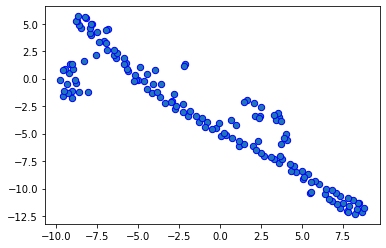

In [21]:
tsne=TSNE()
show_reduced = tsne.fit_transform(pca_coord)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()


Подобное преобразование можно сравнить с построением проекции глобуса - карты. При построении такой проекции мы тоже пытаеммся снизить размерность трехмерной фигуры до двух измерений. При этом могут использоваться искажения, то есть мы будем сжимать и растягивать карту. При этом могут возникать разрывы в разных местах. В любом случае, точки, которые были рядом (например, по границе карты) оказываются разнесены друг от друга.

На самом деле, t-SNE случайным образом разбрасывает точки по пространству нужной размерности, а потом проводит оптимизацию функционала взаимодействия между точками. ([Видео с объяснениями](https://www.youtube.com/watch?v=NEaUSP4YerM))

Примерно такая же картина в смысле разрывов и искажений наблюдается при применении методов наподобие t-SNE. Для разных начальных расположений точек будет получаться разная картина для искажений.

<img src="img/scale_1200.webp" width="400">
<img src="img/675px-Goode_homolosine_projection_SW.jpg" width="400">
<img src="img/0c41ef6a88a84deaaccf18ae2a5862cd.jpg" width="400">
<img src="img/675px-Bonne_projection_SW.jpg" width="400">

Больше примеров проекций см. <a href = "https://xkcd.com/977/">здесь</a>.



Наконец, алгоритм, который появился в 2018 году - UMAP (<i>Uniform Manifold Approximation and Projection</i>). Принцип работы аналогичен t-SNE. Посмотрим и на его результаты.<br>
<b>Внимание!!!</b><br>
Для установки используйте umap-learn (https://pypi.org/project/umap-learn/)<br>
Его интерфейс отличается от библиотеки umap.

`pip install umap-learn`

In [17]:
import umap

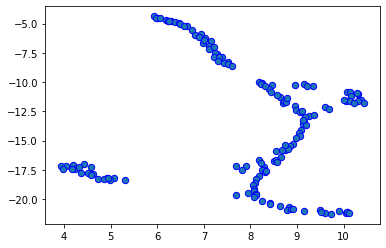

In [18]:
umap_emb = umap.UMAP()
show_reduced = umap_emb.fit_transform(pca_coord)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()


Теперь посмотрим что сделают эти преобразования с сеткой.

In [11]:
grid_coord=np.array(np.meshgrid(np.arange(10), np.arange(10), np.arange(10), np.arange(10))).T.reshape(-1,4)

Ниже специально приведены значения времени, которое потреовалось для расчета. Вы можете оценить, стоит ли запускать, или можно просто посмотреть на результат.

<IPython.core.display.Javascript object>


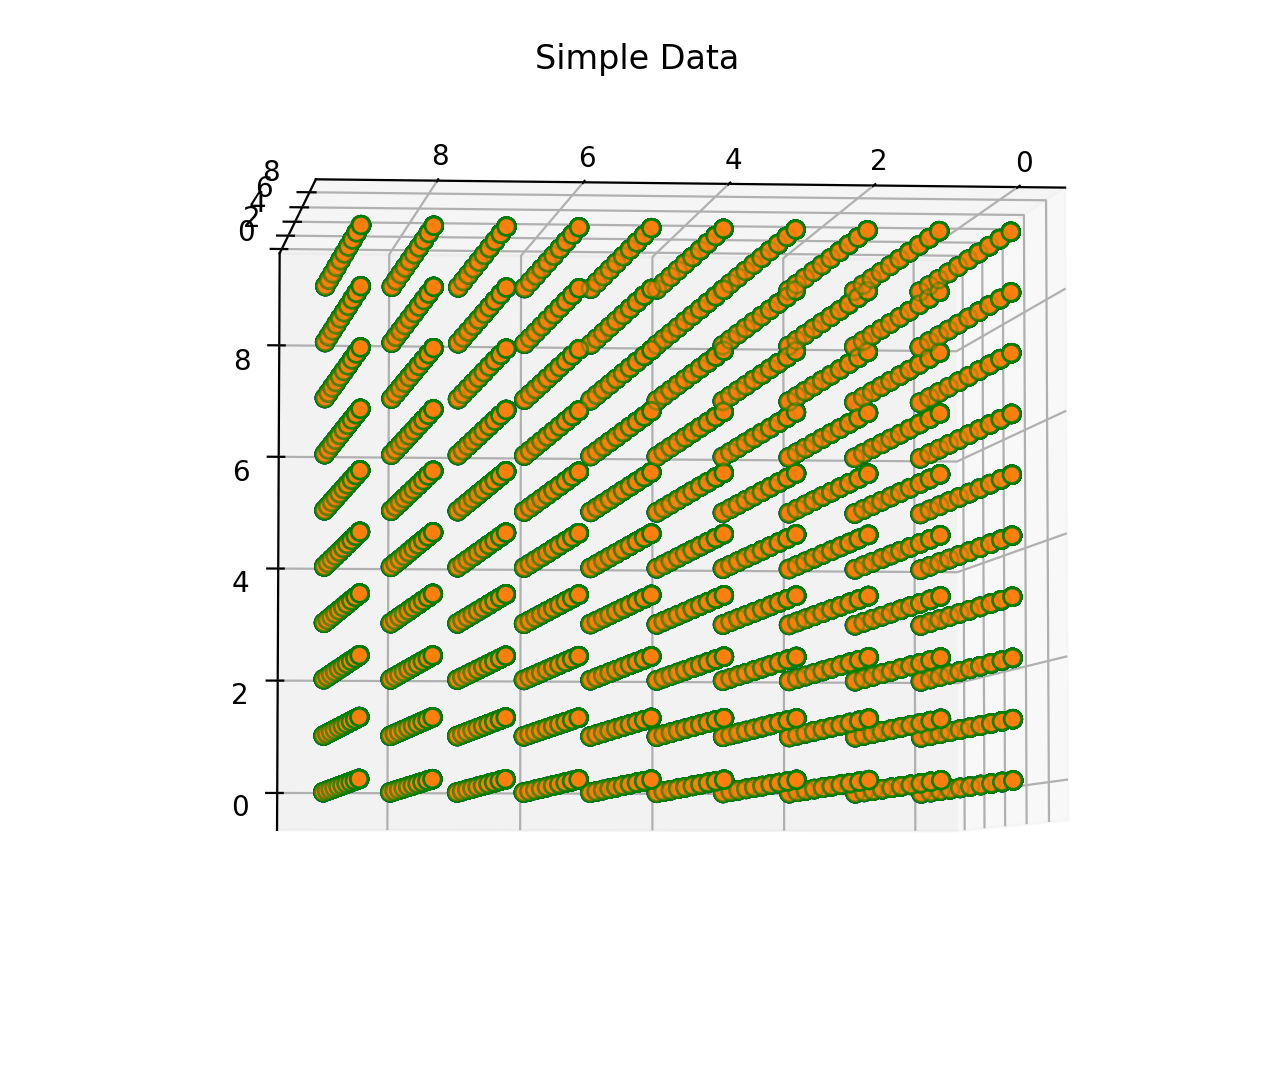

<IPython.core.display.Javascript object>


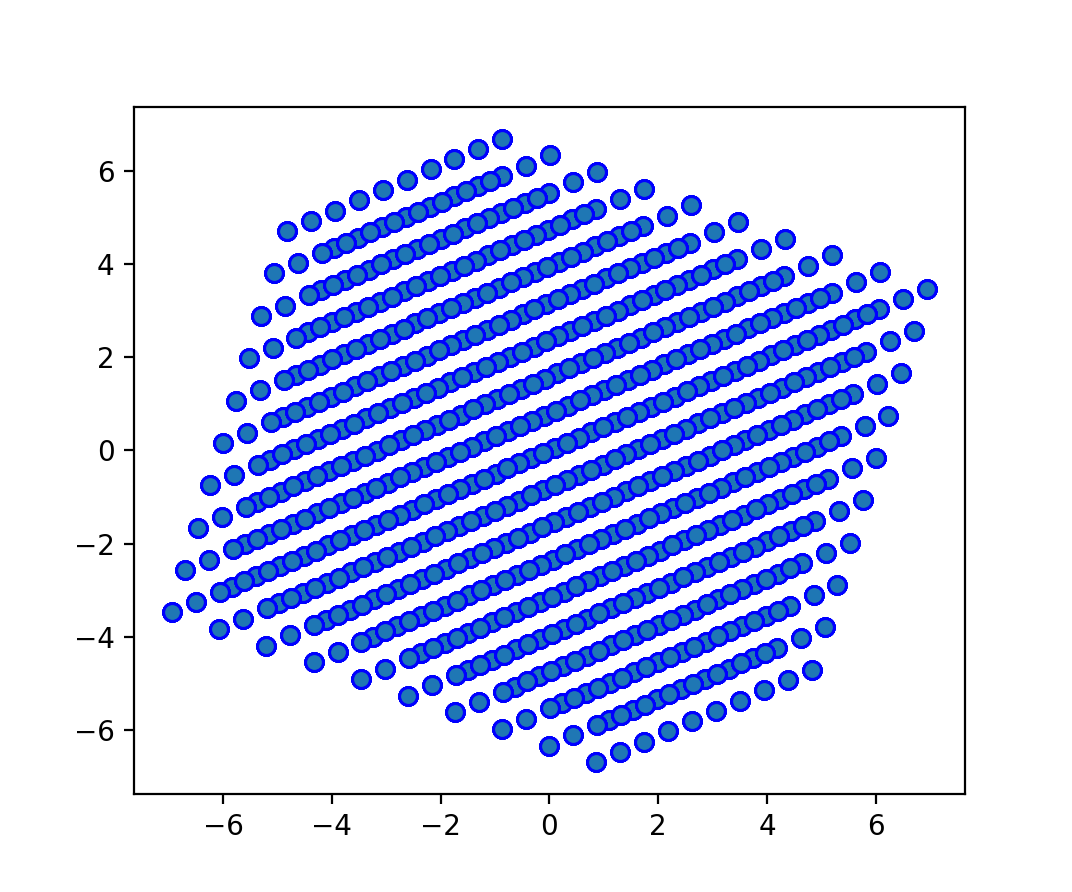

CPU times: user 412 ms, sys: 600 ms, total: 1.01 s
Wall time: 213 ms


In [12]:
%%time

plot_PCA(grid_coord)

<IPython.core.display.Javascript object>


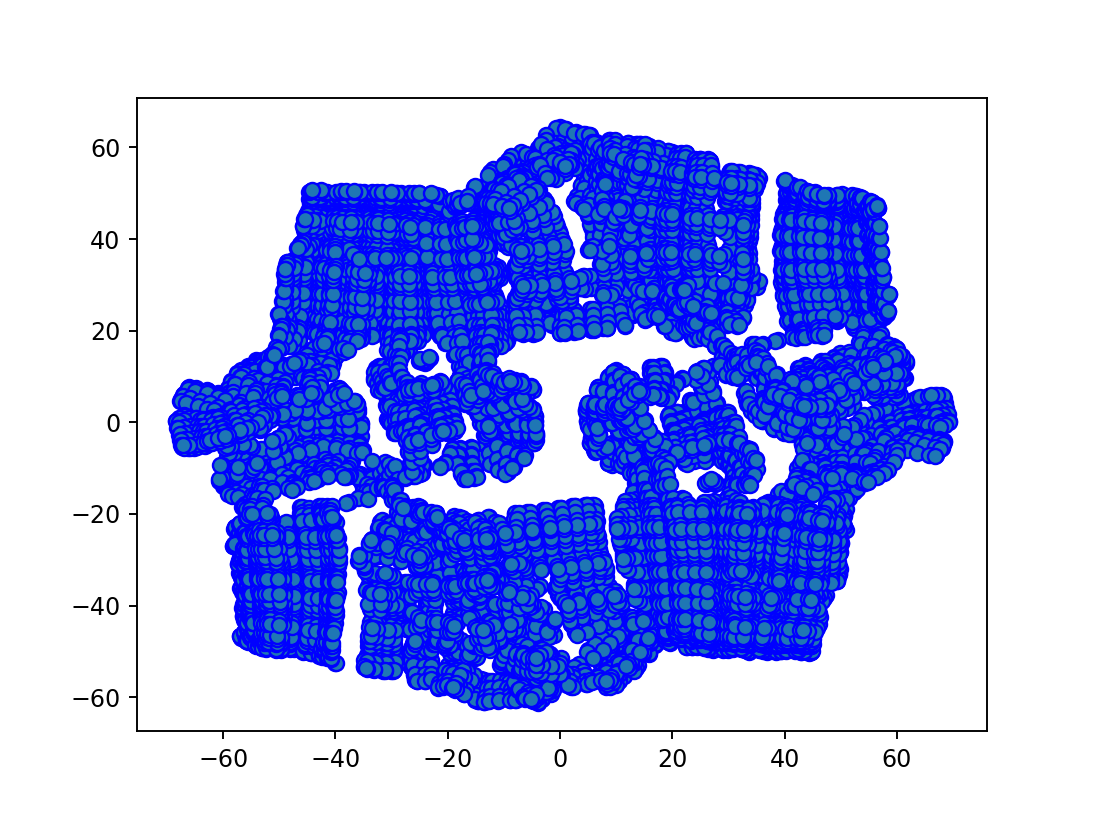

CPU times: user 2min 5s, sys: 17.1 s, total: 2min 22s
Wall time: 2min 23s


In [18]:
%%time
show_reduced = tsne.fit_transform(grid_coord)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

<IPython.core.display.Javascript object>


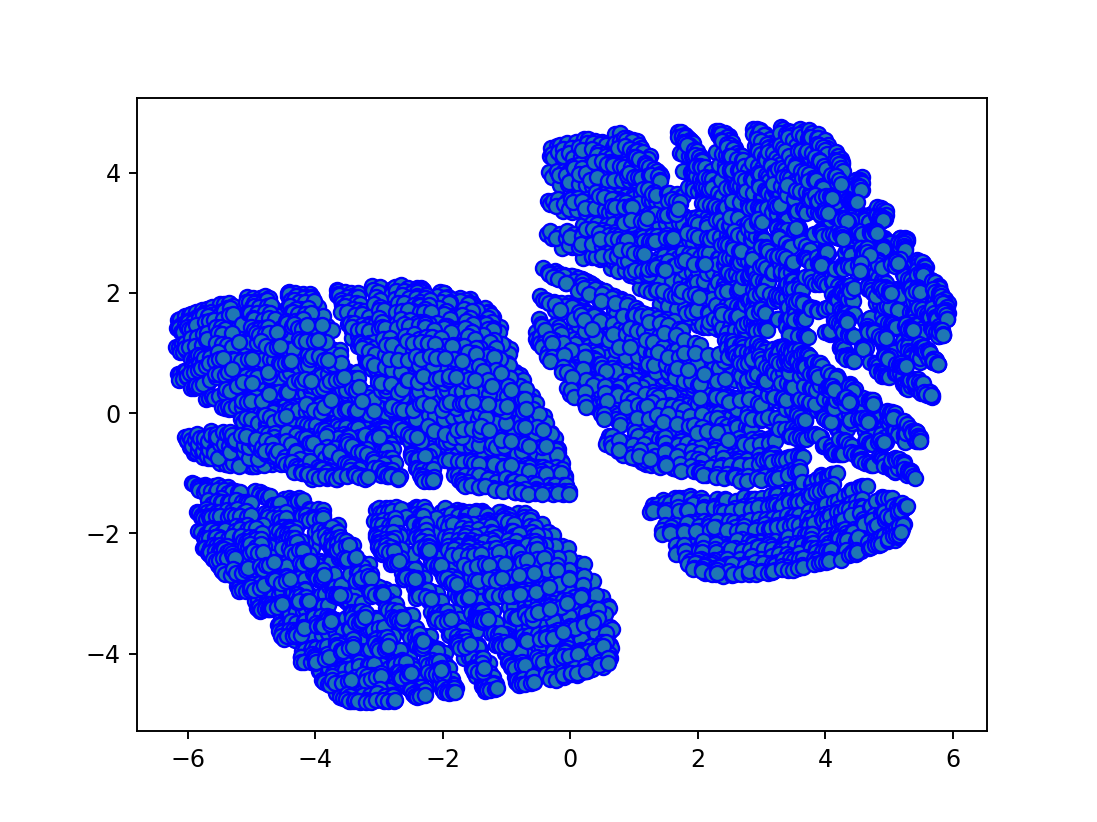

CPU times: user 34.7 s, sys: 2.47 s, total: 37.2 s
Wall time: 33.4 s


In [19]:
%%time
show_reduced = umap_emb.fit_transform(grid_coord)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

Теперь посмотрим на три непересекающихся кластера, которые были сгенерированы в начале лекции.

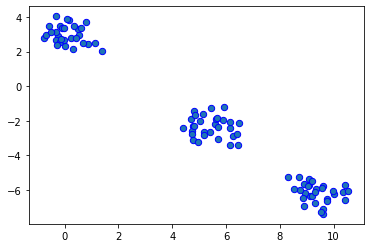

CPU times: user 6.36 s, sys: 73.2 ms, total: 6.44 s
Wall time: 1.41 s


In [56]:
%%time
show_reduced = TSNE().fit_transform(blob_X)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

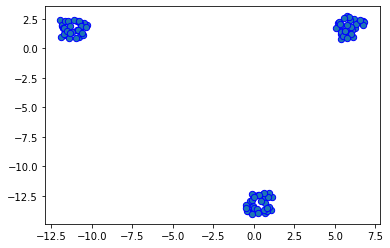

CPU times: user 4 s, sys: 144 ms, total: 4.15 s
Wall time: 4.22 s


In [58]:
%%time
show_reduced = umap.UMAP().fit_transform(blob_X)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

Теперь посмотрим на классику - ирисы Фишера.

In [22]:
from sklearn.datasets import load_iris

In [23]:
iris = sns.load_dataset('iris')

In [24]:
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

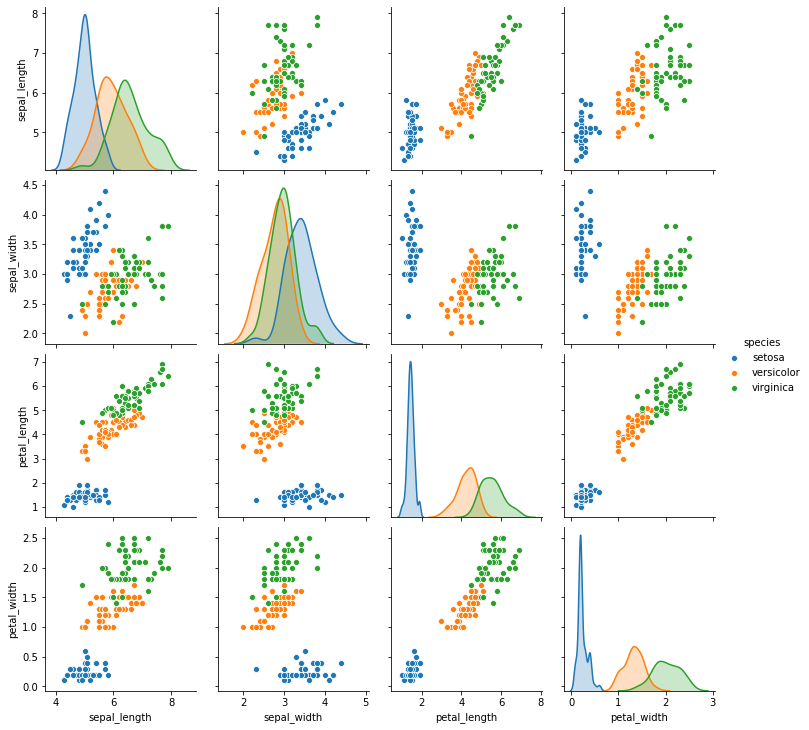

In [25]:
sns.pairplot(iris, hue='species');

In [26]:
X = iris.iloc[:, :4].values

mapping = dict((s, i) for i, s in enumerate(iris.species.unique()))
y = iris.species.replace(mapping).values

X.shape

(150, 4)

In [27]:
pca = PCA(n_components=2)
pca.fit(X)
PC = pca.transform(X)
PC.shape

(150, 2)

In [28]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [24]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

<IPython.core.display.Javascript object>


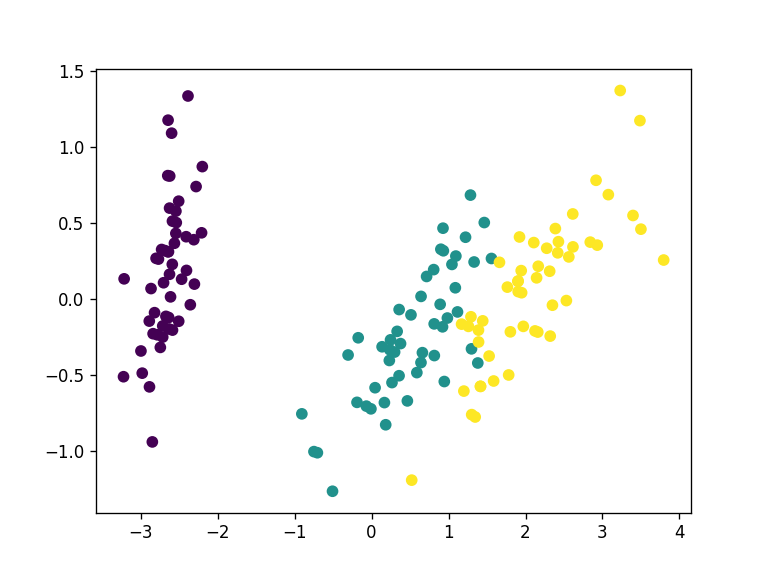

In [26]:
plt.scatter(PC[:,0], PC[:,1],c=y);

Взглянем на t-SNE.

In [29]:
tsne = TSNE(n_components=2)
tsne_iris = tsne.fit_transform(X)
tsne_iris.shape

(150, 2)

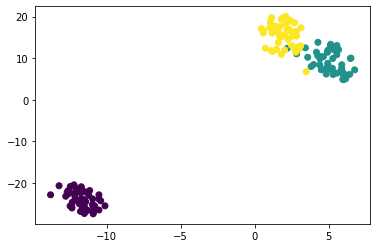

In [30]:
plt.scatter(tsne_iris[:,0], tsne_iris[:,1],c=y);

In [31]:
umap_i = umap.UMAP()
umap_iris = umap_i.fit_transform(X)
umap_iris.shape

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


(150, 2)

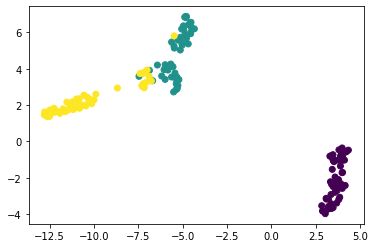

In [32]:
plt.scatter(umap_iris[:,0], umap_iris[:,1],c=y);

In [33]:
%matplotlib inline

from ipywidgets import interact, IntSlider

In [34]:
def umapped_irises(n, c, s):
    fig, ax = plt.subplots()

    umap_i = umap.UMAP(n_neighbors=n, local_connectivity=c, repulsion_strength=s, random_state=1234)
    umap_iris = umap_i.fit_transform(X)
    ax.scatter(umap_iris[:,0], umap_iris[:,1], c = y);
    plt.show()

In [35]:
#fig, ax = plt.subplots()

_=interact(umapped_irises, n=IntSlider(min=1, max=50, value=14, step=1), 
          c=IntSlider(min=1, max=10, value=1, step=1), s=IntSlider(min=1, max=10, value=1, step=1))


interactive(children=(IntSlider(value=14, description='n', max=50, min=1), IntSlider(value=1, description='c',…

Рассмотренные методы обладают следующими достоинствами и недостатками.
- PCA 
    * быстрый (+);
    * повторяющиеся результаты (+);
    * можно добавить новые точки (+);
    * строит проекцию, то есть часть данных теряется (-).
- t-SNE и UMAP 
    * стараются сохранить расстояния между точками (+);
    * это достигается за счет нелинейных искажений (+-);
    * медленнее PCA (-);
    * а текущий момент добавление новых точек возможно только для реализаций UMAP.
- MDS - занимает промежуточное положение среди двух групп методов.
    

А теперь посмотрим как выглядят на плоскости пассажиры "Титаника".<br>
Подробно о том как можно анализировать этот набор данных - <a href="https://habr.com/post/202090/">здесь</a>.

In [19]:
titanic_data2=pd.read_csv("data/00_titanic_train.csv")

In [20]:
titanic_data2.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [18]:
titanic_data2=titanic_data2.replace({'Sex': 'male'}, 0)
titanic_data2=titanic_data2.replace({'Sex': 'female'}, 1)
titanic_data2=titanic_data2.replace({'Embarked': 'S'}, 0)
titanic_data2=titanic_data2.replace({'Embarked': 'C'}, 1)
titanic_data2=titanic_data2.replace({'Embarked': 'Q'}, 2)
# Для некоторых пассажиров возраст не указан. Заменяем его на медиану или нормальное распределение вокруг нее.
#titanic_data2.Age[titanic_data2.Age.isnull()]=titanic_data2.Age.median()
titanic_data2.Age[titanic_data2.Age.isnull()]=np.random.normal(loc=titanic_data2.Age.median(), scale=3,
                                                               size=(len(titanic_data2.Age[titanic_data2.Age.isnull()])))
titanic_data=titanic_data2[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']].dropna()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
titanic_data.head()

Survived  Pclass  Sex   Age  SibSp  Parch  Embarked
0         0       3    0  22.0      1      0       0.0
1         1       1    1  38.0      1      0       1.0
2         1       3    1  26.0      0      0       0.0
3         1       1    1  35.0      1      0       0.0
4         0       3    0  35.0      0      0       0.0

<IPython.core.display.Javascript object>


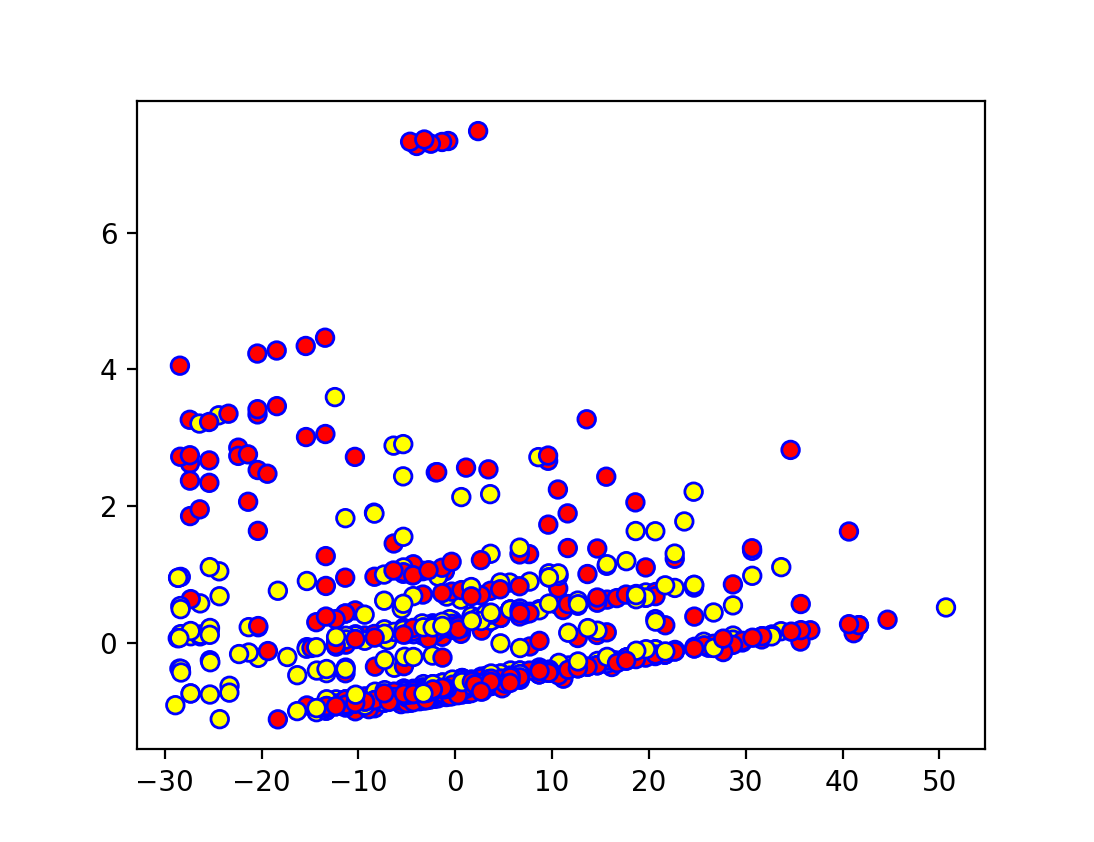

In [19]:
pca=PCA(n_components=2)
show_reduced = pca.fit_transform(titanic_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']])

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], c=titanic_data.Survived,
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

<IPython.core.display.Javascript object>


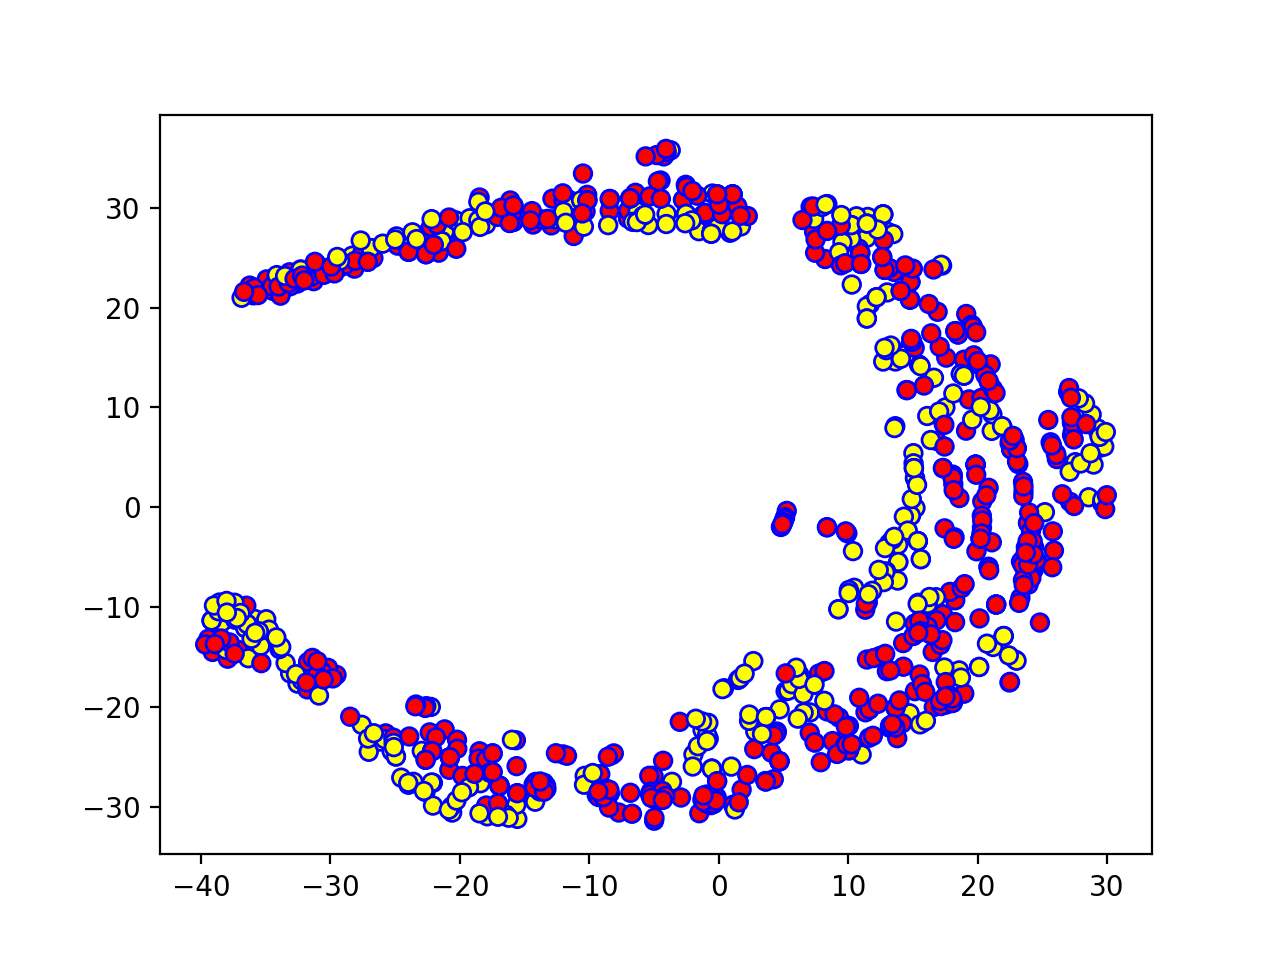

In [20]:
show_reduced = tsne.fit_transform(titanic_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']])

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], c=titanic_data.Survived,
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

<IPython.core.display.Javascript object>


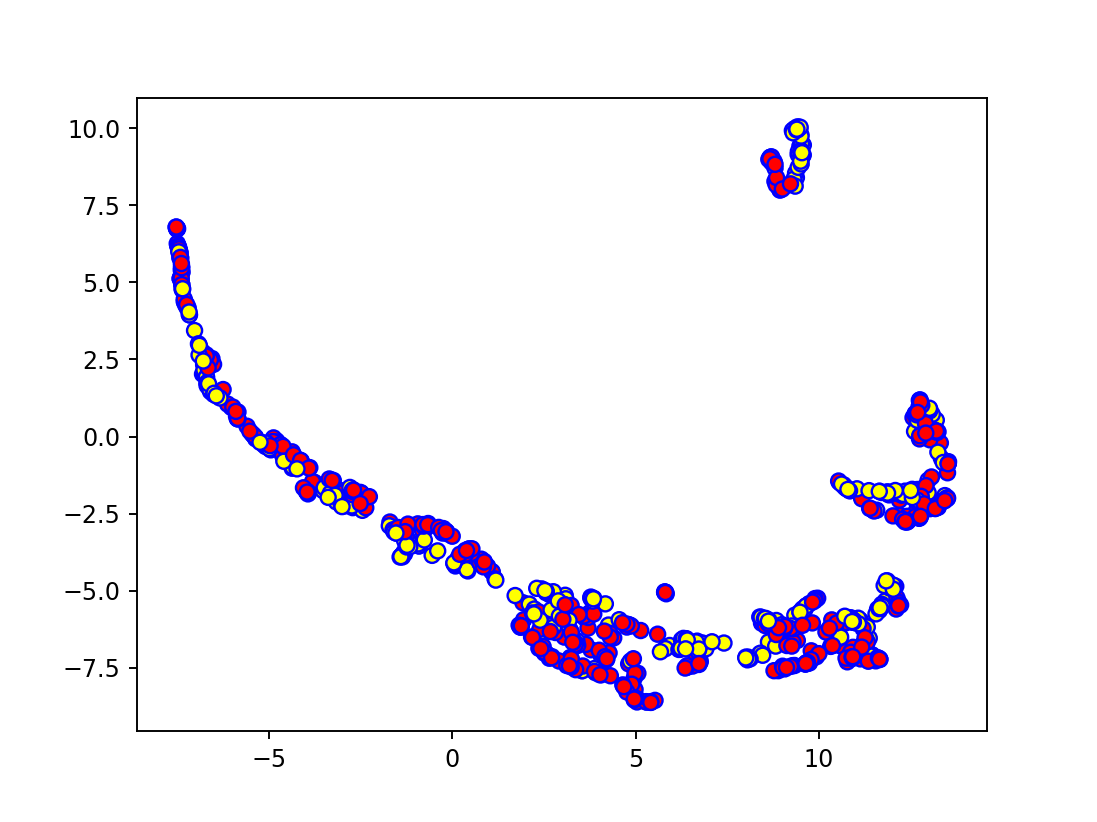

In [34]:
show_reduced = umap_emb.fit_transform(titanic_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']])

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], c=titanic_data.Survived,
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

<IPython.core.display.Javascript object>


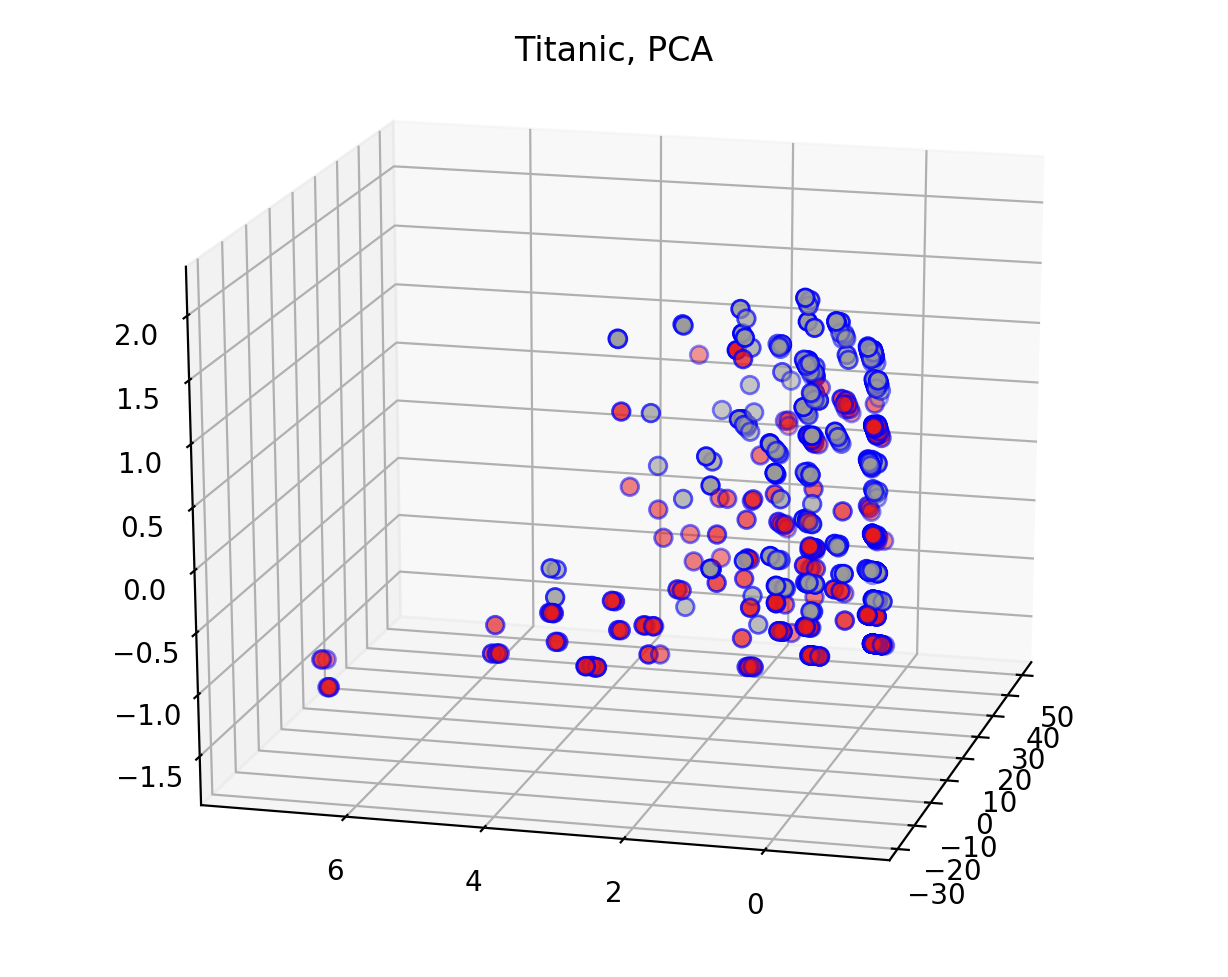

In [22]:
pca3=PCA(n_components=3)
show_reduced = pca3.fit_transform(titanic_data)

fig = plt.figure(2, figsize=(8, 6))
ax = Axes3D(fig, elev=60, azim=150)
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], show_reduced[:, 2], c=titanic_data.Survived, 
               cmap=plt.cm.Set1, edgecolor='b', s=40)
ax.set_title("Titanic, PCA")

plt.show()

<IPython.core.display.Javascript object>


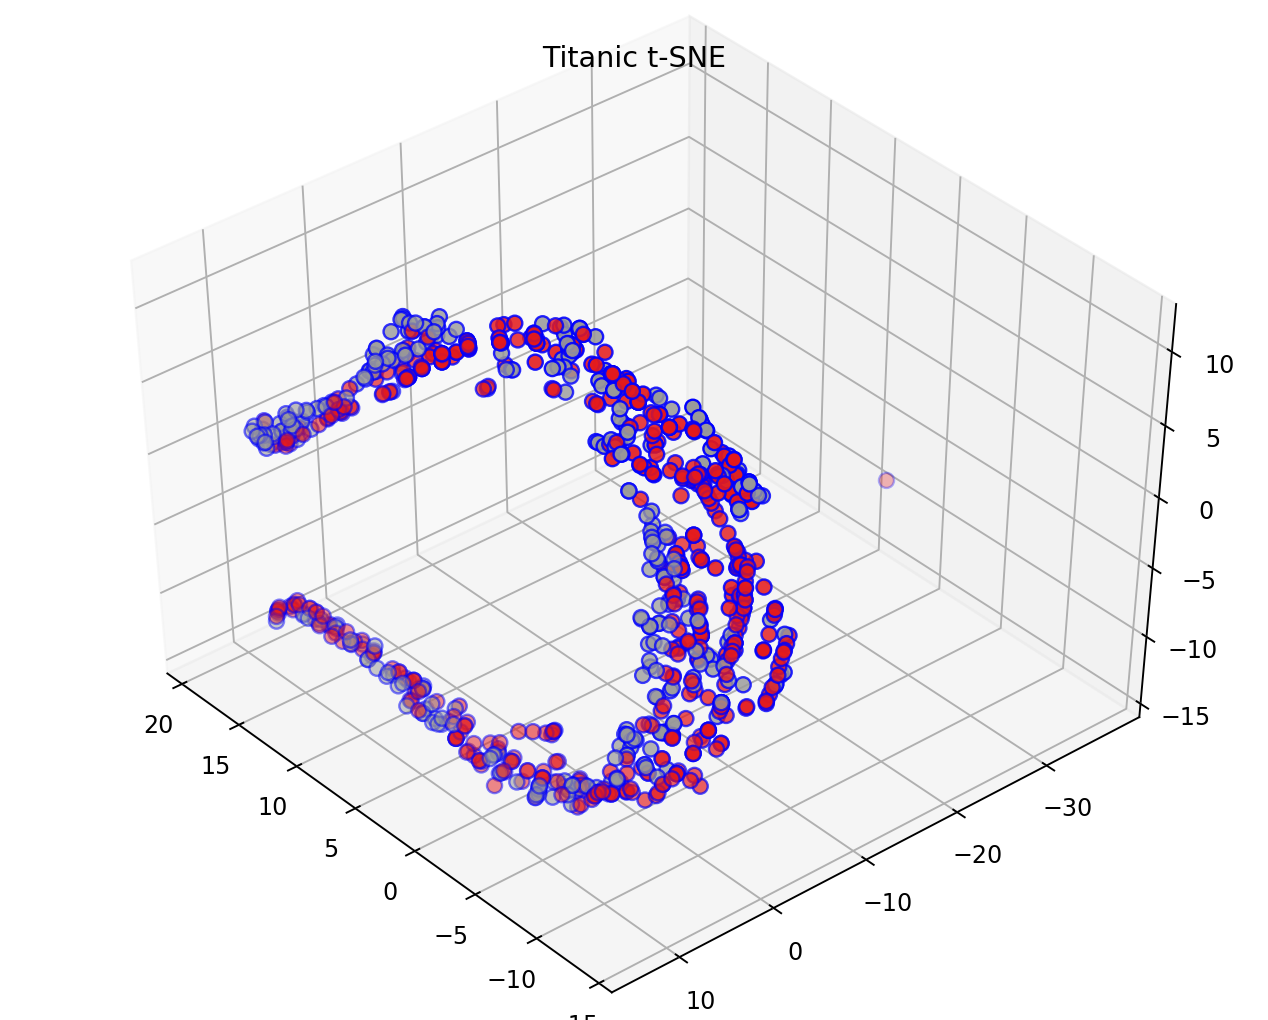

In [36]:
tsne3=TSNE(n_components=3)
show_reduced = tsne3.fit_transform(titanic_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']])

fig = plt.figure(3, figsize=(8, 6))
ax = Axes3D(fig, elev=60, azim=150)
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], show_reduced[:, 2], c=titanic_data.Survived, 
               cmap=plt.cm.Set1, edgecolor='b', s=40)
ax.set_title("Titanic t-SNE")

plt.show()

Кроме того, попробуем посмотреть как изменятся результаты классификации после применения преобразования пространства.

In [23]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import cross_validation

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
scores = cross_validation.cross_val_score(RandomForestClassifier(n_jobs=4, n_estimators=40, criterion="entropy"), 
                                          titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']], 
                                          titanic_data['Survived'], 
                                          cv = 30)
print(scores.mean())

0.7868434062538625


In [39]:
reduced_titanic = pca3.fit_transform(titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']])

scores = cross_validation.cross_val_score(RandomForestClassifier(n_jobs=4, n_estimators=40, criterion="entropy"), 
                                          reduced_titanic, titanic_data['Survived'], 
                                          cv = 30)
print(scores.mean())

0.7487986651835373


In [40]:
reduced_titanic = tsne3.fit_transform(titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']])

scores = cross_validation.cross_val_score(RandomForestClassifier(n_jobs=4, n_estimators=40, criterion="entropy"), 
                                          reduced_titanic, titanic_data['Survived'], 
                                          cv = 30)
print(scores.mean())

0.7350105054999381


In [36]:
from sklearn.datasets import load_digits

In [37]:
digits = load_digits()

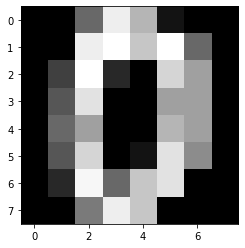

In [38]:
img = digits.images
plt.imshow(img[0], cmap=plt.cm.Greys_r);

In [39]:
img[0].shape

(8, 8)

In [40]:
X = img.reshape(-1, 64)

In [41]:
X.shape

(1797, 64)

In [42]:
y = digits.target

In [43]:
tsne2d=PCA(n_components=2)
show_reduced = tsne2d.fit_transform(X)


In [44]:
len(show_reduced)

1797

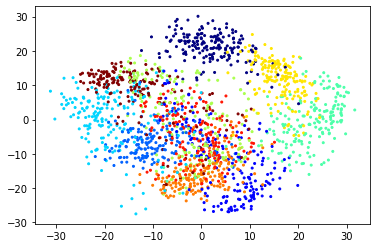

In [45]:
fig, ax = plt.subplots()
ax.scatter([x[0] for x in show_reduced], [x[1] for x in show_reduced], c=y,
           cmap=plt.cm.jet, s=4)
plt.show()

In [46]:
tsne2d2=umap.UMAP(n_components=2)
show_reduced = tsne2d2.fit_transform(X)


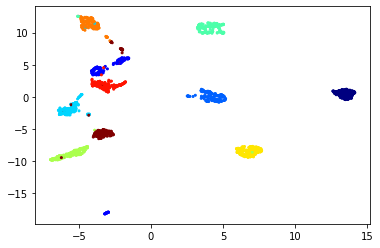

In [47]:
fig, ax = plt.subplots()
ax.scatter([x[0] for x in show_reduced], [x[1] for x in show_reduced], c=y,
           cmap=plt.cm.jet, s=4)
plt.show()

Рассмотренные методы позволяют проводить следующие действия:
- визуализировать многомерные данные в ходе предварительного анализа, визуализация позволяет прийти к преварительным выводам о возмоности или невозможности применения разных методов анализа;
- снизить размерность анализируемых данных и получить выигрыш в скорости обработки;
- точность анализа после преобразования пространства может как снизиться, так и увеличиться в зависимости от природы данных;
- методы t-SNE и UMAP позволяют работать с предварительно рассчитанными матрицами расстояниями между точками, за счет этого можно преобразовать неметрическое пространство в метрическое.